In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os

from joblib import dump, load
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Fix random seed
seed = 42
np.random.seed(seed)
random.seed(seed)

# Pre-processing input data

In [2]:
# train_df and test_df are created in eda notebook
if not os.path.exists('csv/train_df.csv') or not os.path.exists('csv/test_df.csv'):
	print('Please run the eda notebook first')
	exit()
train_df = pd.read_csv('csv/train_df.csv')
test_df = pd.read_csv('csv/test_df.csv')
target = 'total_time_target'
features = ["total_time"]

# log for total_times
train_df[[target, 'total_time']] = np.log1p(train_df[[target, 'total_time']])
test_df[[target, 'total_time']] = np.log1p(test_df[[target, 'total_time']])

# Split data
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Normalize data
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

In [3]:
if not os.path.exists('../models/x_scaler.joblib') or not os.path.exists('../models/y_scaler.joblib'):
	dump(x_scaler, '../models/x_scaler.joblib')
	dump(y_scaler, '../models/y_scaler.joblib')

# Training

In [4]:
def inv_scaling(y, y_scaler):
    return y_scaler.inverse_transform(y.reshape(-1, 1))

In [5]:
model = LinearRegression()
model.fit(X_train, y_train)

# Train
predictions_train = model.predict(X_train)
loss = np.sqrt(mean_squared_error(y_train, predictions_train))

# Test
predictions = model.predict(X_test)
val_loss = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE Loss : {loss} - RMSE Val Loss: {val_loss}")

RMSE Loss : 0.02439058906309456 - RMSE Val Loss: 0.02302634424484301


In [6]:
# save model
dump(model, f'../models/linear_model_time_only.joblib')

['../models/linear_model_time_only.joblib']

# Load models

In [7]:
model = load('../models/linear_model_time_only.joblib')

In [8]:
def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}

	predictions = model.predict(X)
	predictions = np.expm1(inv_scaling(predictions, y_scaler))
	y_scaled = np.expm1(inv_scaling(y, y_scaler))
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [9]:
test_df_og = pd.read_csv('csv/test_df.csv')

In [10]:
_, _, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test, y_scaler))
df = pd.DataFrame(predictions, columns=['predictions'])
df['actual'] = y_scaled
df.to_csv('csv/predictions_lr_time_only.csv', index=False)

In [11]:
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 24.379473457074813 | Std actual: 46.07982850332896
Mean actual: 23.631032844733987 | Std actual: 41.60096829835196
Mean Error: 3.829233363070097 | Std Error: 9.356633487923563
Min instance
total_time                                                            20.31
total_cpu_usage                                                        0.99
max_ram_usage                                                     30.707031
brand_raw                         Intel(R) Xeon(R) CPU E5-2643 v3 @ 3.40GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    12
l2_cache_size                                                           3.0
l3_cache_size                                                          20.0
l2_cache_line_size                                                      256

coef: 0.9948377746112412 | intercept: 0.0017408692122404257


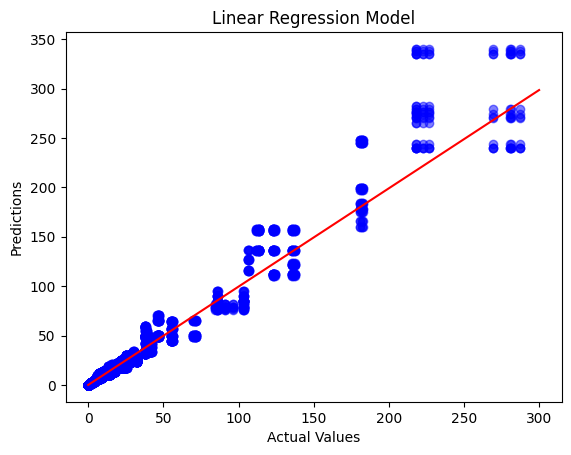

In [12]:
print("coef:",model.coef_.item(), "| intercept:",model.intercept_.item())
# Plot predictions
plt.scatter(y_scaled, predictions, alpha=0.5, color='b')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Linear Regression Model')
# Plot a line with model's parameters
x = np.linspace(0, 300, 300)
y = model.coef_.item() * x + model.intercept_.item()
plt.plot(x, y, color='r')
plt.show()